In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import random
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
import random as rand
from tqdm import tqdm
from skimage.io import imread
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [4]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
base_path = Path.cwd().parent / 'Data Sets/2023_01_24_main-set'

images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

#Example image to look at: 
image_num = str(88)

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))

um_per_px = 2.2

In [5]:
raw_tif = imread(images_folder / '{}.tif'.format(image_num))


/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed i

<Axes: xlabel='timepoint', ylabel='circle_radius'>

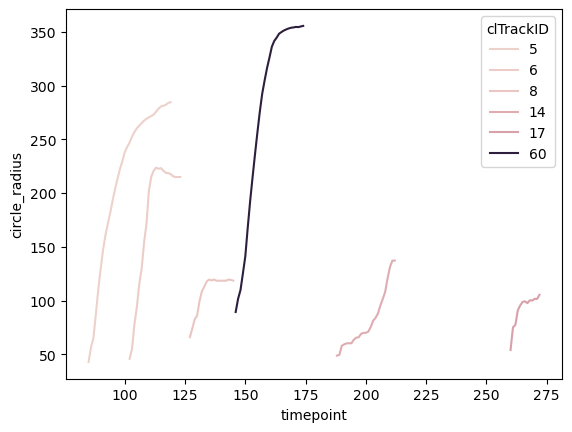

In [6]:
sns.lineplot(data=wave_df, x='timepoint', y='circle_radius', hue='clTrackID')

In [9]:
#Lets select the example wave:
ex_wave_num = 5
ex_wave_DF = wave_df[wave_df['clTrackID']==ex_wave_num]
ex_arcos_DF = arcos_df[arcos_df['clTrackID']==ex_wave_num]
start_time = ex_wave_DF.timepoint.min()
pre_wave_time = start_time - 12 #one min prior to wave
end_time = ex_wave_DF.timepoint.max()
post_wave_time = end_time + 2 #four min after wave

In [10]:
ex_wave_DF[ex_wave_DF['timepoint']==start_time]

,clTrackID,timepoint,rel_time,rel_r,r_squared,circle_radius,radius_velocity,radius_acceleration,wave_centroid,cell_density,trackable,ca_avg_sig,split,drug_name,drug_dose,volunteer_ID
0,5,85,0,0.0,0.0,42.97213,2.721848,-0.103112,"[199.59987326153325, 236.67196595149252]",9643.381914,True,380.19678,0.0,NaN,NaN,16


In [11]:
#Getting a circle from set: 
ex_time = end_time
vmin_set = 200
vmax_set = 1000
border_color = '#87ABD3'
border_width = 12
crop_buffer = 160

i_wave_center = ex_wave_DF[ex_wave_DF['timepoint']==start_time].wave_centroid.values[0]
i_wave_center = [int(val) for val in i_wave_center]

i_wave_r = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].circle_radius.values[0]/2.2 #need to convert back from um to px
wave_center = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].wave_centroid.values[0]
i_wave_center = [int(val) for val in i_wave_center]

In [12]:
crop_buffer = 175
crop_im = raw_tif[ex_time, 0,:,:][i_wave_center[1]-crop_buffer:i_wave_center[1]+crop_buffer,i_wave_center[0]-crop_buffer:i_wave_center[0]+crop_buffer]

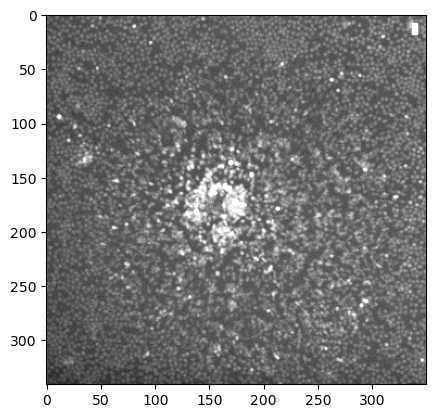

In [13]:
fig, ax = plt.subplots()
ax.imshow(crop_im, cmap='Greys_r', vmin=100, vmax=900)
scalebar = AnchoredSizeBar(ax.transData,
                           10/um_per_px, '',  'upper right', 
                           pad=0.5,
                           color='white',
                           frameon=False,
                           size_vertical=10)

ax.add_artist(scalebar)

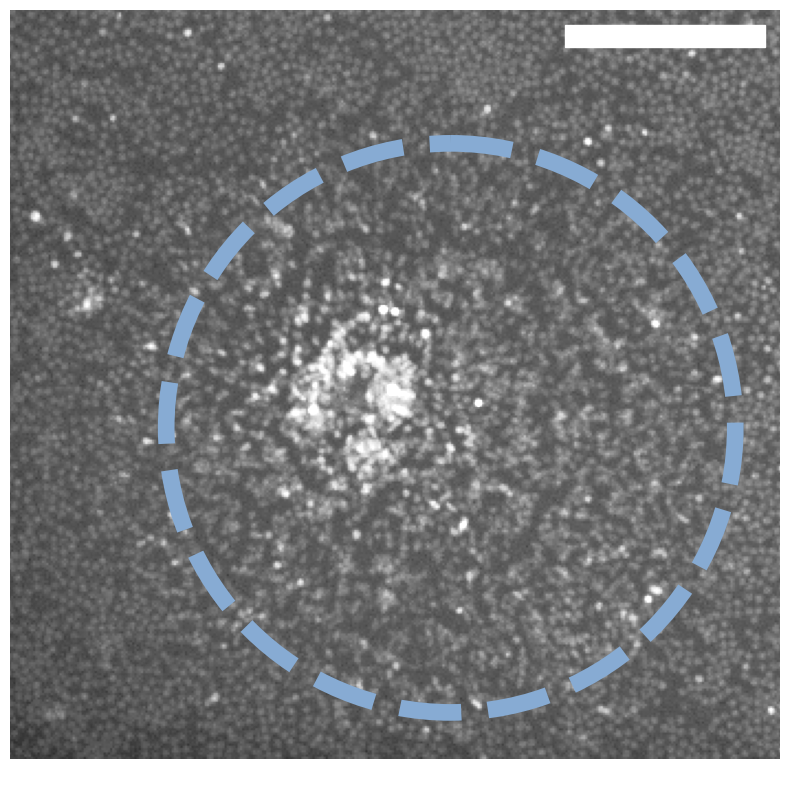

In [14]:
#Lets start by getting the first frame of the wave? 
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(raw_tif[ex_time, 0,:,:], cmap='Greys_r', vmin=50, vmax=1000)
ax.axis('off')
circle1 = plt.Circle(wave_center, i_wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width)
ax.add_patch(circle1)
plt.ylim(i_wave_center[1]-crop_buffer,i_wave_center[1]+crop_buffer)
plt.xlim(i_wave_center[0]-crop_buffer,i_wave_center[0]+crop_buffer)
plt.gca().invert_yaxis()
scalebar = AnchoredSizeBar(ax.transData,
                           200/um_per_px, '',  'upper right', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=10)

ax.add_artist(scalebar)

In [23]:
#Make a directory for the stills to live in corresponding to image from set in main used: 
Path.mkdir(Path.cwd() / '1b_stills' / image_num)


FileExistsError: [Errno 17] File exists: '/Users/echo/Documents/Lab Stuff/Publication/23 Protofigures/Fig1 - Calcium Wave/1b_stills/88'

In [25]:
export_location = Path.cwd() / '1b_stills' / image_num


In [48]:
#Save a set of panels during wave propagation: 
vmin_set = 150
vmax_set = 800
border_color = '#87ABD3'
border_width = 12
crop_buffer = 160

i_wave_center = ex_wave_DF[ex_wave_DF['timepoint']==start_time].wave_centroid.values[0]
i_wave_center = [int(val) for val in i_wave_center]

for t in ex_wave_DF.timepoint.values:
    wave_r = ex_wave_DF[ex_wave_DF['timepoint']==t].circle_radius.values[0]/2.2 #need to convert back from um to px
    wave_center = ex_wave_DF[ex_wave_DF['timepoint']==t].wave_centroid.values[0]
    crop_im = raw_tif[t, 0,:,:][i_wave_center[1]-crop_buffer:i_wave_center[1]+crop_buffer,i_wave_center[0]-crop_buffer:i_wave_center[0]+crop_buffer]
    wave_center_translate = [wave_center[0] - i_wave_center[0] + crop_buffer, wave_center[1] - i_wave_center[1] + crop_buffer]
    #Lets start by getting the first frame of the wave? 
    fig, ax = plt.subplots(figsize=(10,10))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(crop_im, cmap='magma', vmin=vmin_set, vmax=vmax_set)
    circle1 = plt.Circle(wave_center_translate, wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width)
    ax.add_patch(circle1)
    scalebar = AnchoredSizeBar(ax.transData,
                           200/um_per_px, '',  'upper right', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=10)

    ax.add_artist(scalebar)
    save_file_loc = export_location / str(image_num + '-{}.png'.format(t))
    plt.savefig(save_file_loc, dpi=300)
    plt.close()

In [47]:
#Save a set of panels during wave propagation: 
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
pre_wave_time = min(ex_wave_DF.timepoint.values) - 12
crop_im = raw_tif[pre_wave_time, 0,:,:][i_wave_center[1]-crop_buffer:i_wave_center[1]+crop_buffer,i_wave_center[0]-crop_buffer:i_wave_center[0]+crop_buffer]
plt.imshow(crop_im, cmap='magma', vmin=vmin_set, vmax=vmax_set)
scalebar = AnchoredSizeBar(ax.transData,
                           200/um_per_px, '',  'upper right', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=10)

ax.add_artist(scalebar)
save_file_loc = export_location / str(image_num + '-{}.png'.format(pre_wave_time))
plt.savefig(save_file_loc, dpi=300)
plt.close()

In [29]:
#Now for the tracks: 
tracks = tracking_df.groupby('track_id')

#get the tracks that arcos says are inside the wave...
track_collect = []
outer_tracks = []
track_min_len = 24

for i, track in tqdm(tracks): 
    if i in ex_arcos_DF.track_id.unique():
        if len(track) > track_min_len:
            track_collect.append(track[track['timepoint'].between(start_time, post_wave_time)])
    else:
        outer_tracks.append(track[track['timepoint'].between(start_time, post_wave_time)])
        
tracks_in_wave = pd.concat(track_collect, ignore_index=True)
tracks_out_wave = pd.concat(outer_tracks, ignore_index=True)

100%|█████████████████████████████████████| 21126/21126 [00:04<00:00, 4814.33it/s]


In [31]:
#sample_size = 20000
#track_subset = random.sample(list(tracking_df.track_id.unique()),sample_size)

subset_collect = []

for i, track in tracking_df.groupby('track_id'):
    #if i in track_subset:
    track = track[track['timepoint'].between(start_time, post_wave_time)]
    if len(track) > 24:
        #Get the time, x, and y points --> Smooth x and y on time... 
        time = track.timepoint.values*5.0
        x_smooth = UnivariateSpline(time, track.x.values, s=10)
        y_smooth = UnivariateSpline(time, track.y.values, s=10)

        #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
        coords = np.stack((np.array(x_smooth(time)), np.array(y_smooth(time))), axis=1)
        lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
        radial_vec = [np.array([wave_center[0] - coords[i][0], wave_center[1] - coords[i][1]]) for i in range(len(coords))]
        dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
        velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
        angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
        cis = np.cos(angles)
        radial_velocity = velocity*cis

        #Append the relevant parameters to the track: 
        track['radial_dist'] = dist_from_center
        track['radial_movement'] = np.max(dist_from_center) - np.min(dist_from_center)
        track['linear_velocity'] = np.insert(velocity, 0, float('nan'), axis=0)
        track['chemotactic_index'] = np.insert(cis, 0, float('nan'), axis=0)
        track['radial_velocity'] = np.insert(radial_velocity, 0, float('nan'), axis=0)
        track['wave_center_distance'] = dist_from_center
        subset_collect.append(track)

subset_tracks = pd.concat(subset_collect, ignore_index=True)

In [30]:
mean_wave_center = ex_wave_DF.wave_centroid.mean()
wave_r = ex_wave_DF[ex_wave_DF['timepoint']==end_time].circle_radius.values[0]/2.2 #need to convert back from um to px

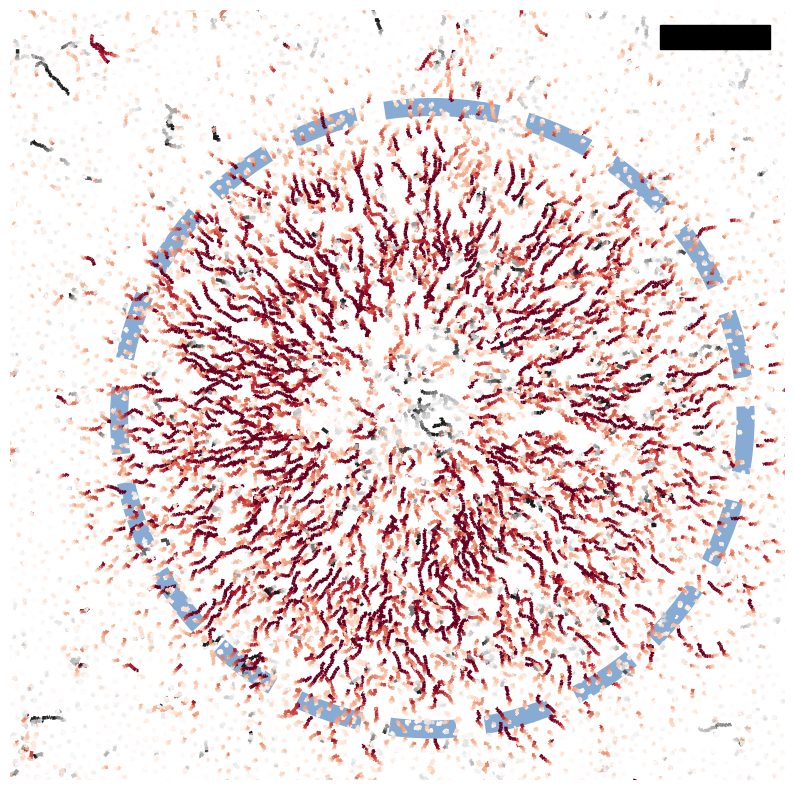

In [44]:
fig, axs = plt.subplots(figsize=(10,10))
#cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

norm = plt.Normalize(-12, 12)
#norm = plt.Normalize(0, 600)
#norm = plt.Normalize(min(subset_tracks.timepoint), max(subset_tracks.timepoint))

for i, track in subset_tracks.groupby('track_id'):
    time_pts = track.x.values
    rs = track.y.values
    points = np.array([time_pts, rs]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    #chemo_index = track.timepoint.values
    #norm = plt.Normalize(min(chemo_index), max(chemo_index))
    chemo_index = track.radial_velocity.rolling(3).mean()
    
    # Create a continuous norm to map from data points to colors

    lc = LineCollection(segments, cmap='RdGy_r', norm=norm)
    # Set the values used for colormapping
    lc.set_array(chemo_index)
    lc.set_linewidth(2.5)
    line = axs.add_collection(lc)
    
#plt.imshow(raw_tif[post_wave_time, 0,:,:], cmap='Greys_r', vmin=50, vmax=1400)
circle1 = plt.Circle(mean_wave_center, wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width+1)
axs.add_patch(circle1)
scalebar = AnchoredSizeBar(axs.transData,
                           100/um_per_px, '',  'upper right', 
                           pad=1,
                           color='black',
                           frameon=False,
                           size_vertical=10)

axs.add_artist(scalebar)
plt.ylim(i_wave_center[1]-crop_buffer,i_wave_center[1]+crop_buffer)
plt.xlim(i_wave_center[0]-crop_buffer,i_wave_center[0]+crop_buffer)
axs.axis('off')
plt.gca().invert_yaxis()
#plt.savefig('fig1-tracks-end-of-wave-3min_{}.png'.format(image_num), bbox_inches='tight', dpi=300, transparent=True)

In [54]:
#sample_size = 20000
#track_subset = random.sample(list(tracking_df.track_id.unique()),sample_size)

all_non_stubs = []
total_wave_center = [int(val) for val in wave_df.wave_centroid.mean()]


for i, track in tqdm(tracking_df.groupby('track_id')):
    if len(track) > 24:
        #Get the time, x, and y points --> Smooth x and y on time... 
        time = track.timepoint.values*5.0
        x_smooth = UnivariateSpline(time, track.x.values, s=10)
        y_smooth = UnivariateSpline(time, track.y.values, s=10)

        #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
        coords = np.stack((np.array(x_smooth(time)), np.array(y_smooth(time))), axis=1)
        lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
        radial_vec = [np.array([total_wave_center[0] - coords[i][0], total_wave_center[1] - coords[i][1]]) for i in range(len(coords))]
        dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
        velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
        angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
        cis = np.cos(angles)
        radial_velocity = velocity*cis

        #Append the relevant parameters to the track: 
        track['radial_dist'] = dist_from_center
        track['total_displacement'] = np.linalg.norm(coords[-1] - coords[0])
        track['radial_movement'] = np.max(dist_from_center) - np.min(dist_from_center)
        track['linear_velocity'] = np.insert(velocity, 0, float('nan'), axis=0)
        track['chemotactic_index'] = np.insert(cis, 0, float('nan'), axis=0)
        track['radial_velocity'] = np.insert(radial_velocity, 0, float('nan'), axis=0)
        track['wave_center_distance'] = dist_from_center
        all_non_stubs.append(track)

stub_rm_tracks = pd.concat(all_non_stubs, ignore_index=True)

100%|██████████████████████████████████████| 21126/21126 [02:56<00:00, 119.54it/s]


(array([2.685281e+06, 9.220370e+05, 3.938330e+05, 1.839760e+05,
        8.124400e+04, 3.467300e+04, 1.659600e+04, 8.316000e+03,
        2.142000e+03, 9.430000e+02]),
 array([2.31146119e-02, 6.82444206e+00, 1.36257695e+01, 2.04270969e+01,
        2.72284244e+01, 3.40297518e+01, 4.08310793e+01, 4.76324067e+01,
        5.44337342e+01, 6.12350616e+01, 6.80363891e+01]),
 <BarContainer object of 10 artists>)

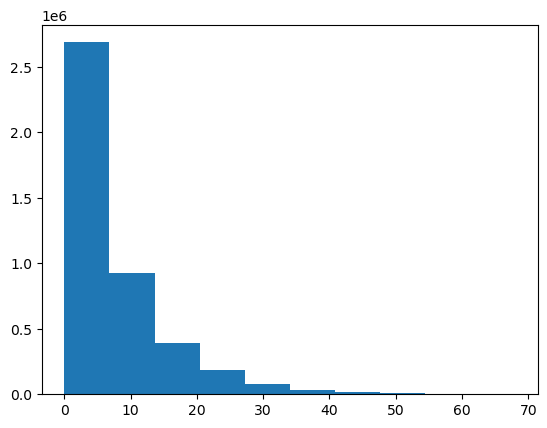

In [55]:
plt.hist(stub_rm_tracks.total_displacement)